In [2]:
from __future__ import division
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, average_precision_score, matthews_corrcoef, make_scorer

from sklearn.feature_selection import SelectKBest,chi2, f_classif, mutual_info_classif, VarianceThreshold

### 1. Download the dataset(s) for your project. If a train set and a test set are not already available, randomly split the dataset into a train and a test set using stratified sampling so that 80% of the samples go to train set and 20% to test set.

Data was retrieved from: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

In [3]:
data = pd.read_csv("data.csv")

y = data['Occupancy']
X = data.loc[:, data.columns != 'Occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

### 2. Randomly split your train set into a validation and a new train set (called train set 2) such that the validation set contains 1/5 of the samples in original train set and the train set 2 contains the remaining. Use stratified sampling to assign features to train set 2 and validation set. This should ensure that your validation set contains samples from both classes (i.e. ciliary and non-ciliary with equal proportions)

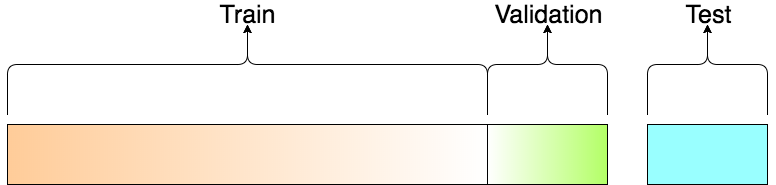

In [4]:
X_train_two, X_validation, y_train_two, y_validation = train_test_split(X_train, y_train, test_size=0.20, 
                                                                        stratify=y_train,random_state=42)

### 3. Normalize features in your train set 2 and validation set using min-max scaling to interval [0,1]. For this purpose you can first normalize features in your train set 2 and use the same scaling coefficients to normalize validation set. Save the normalized versions as separate files. Repeat normalizing your original train set and use the same normalization coefficients to normalize the two test sets.

In [5]:
scaler = MinMaxScaler()

scaler.fit(X_train_two)
normalized_x_train_two = scaler.transform(X_train_two)
normalized_x_validation_train_two = scaler.transform(X_validation)

np.savetxt("normalized_x_train_two.csv", normalized_x_train_two, delimiter=",")
np.savetxt("normalized_x_validation.csv", normalized_x_validation_train_two, delimiter=",")

scaler.fit(X_train)
normalized_x_train = scaler.transform(X_train)
normalized_x_test = scaler.transform(X_test)
normalized_x_validation_with_orig = scaler.transform(X_validation)

### 4. Perform a 10-fold cross-validation experiment for the random forest classifier on normalized and unnormalized versions of train set 2. You can set the number of trees to 100. Do you get better accuracy when you perform data normalization?

In [6]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

unnormalized_accuracy = cross_val_score(clf, X_train_two, y_train_two, cv=10).mean()
normalized_accuracy = cross_val_score(clf, normalized_x_train_two, y_train_two, cv=10).mean()

if unnormalized_accuracy > normalized_accuracy or unnormalized_accuracy == normalized_accuracy:
    print("No, I did not. Unnormalized Accuracy: {}, Normalized Accuracy: {}"
          .format(unnormalized_accuracy,normalized_accuracy))
else:
    print("Yes, I did. Unnormalized Accuracy: {}, Normalized Accuracy: {}"
          .format(unnormalized_accuracy,normalized_accuracy))

No, I did not. Unnormalized Accuracy: 0.992902303093, Normalized Accuracy: 0.992709995401


### 5. Perform a 10-fold cross-validation experiment on train set 2 that corresponds to the best performing normalization strategy (i.e. normalized or unnormalized) for the following classifiers: 

Logistic regression

k-nearest neighbor (with k=1)

Naïve Bayes

Decision tree

Random forest (number of trees=100)

SVM (RBF kernel C=1.0 gamma=0.125)

Linear Discriminant Analysis

Adaboost (number of iterations=10)

You can use default values for other hyper-parameters of the classifiers
Report the following accuracy measures for each of these classifiers: overall
accuracy, F-measure, sensitivity, specificity, precision, area under the ROC curve,
area under the precision recall curve, MCC scores. These will be cross-validation
accuracies.

In [7]:
models = [
    ("Logistic Regression",LogisticRegression(random_state=42)),
    ("K-Nearest Neighbour",KNeighborsClassifier(n_neighbors=1)),
    ("Naive Bayes",GaussianNB()),
    ("Decision Tree",DecisionTreeClassifier(random_state=42)),
    ("Random Forest",RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Support Vector Machine",SVC(kernel="rbf", C=1,gamma=0.125, random_state=42)),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("AdaBoostClassifier",AdaBoostClassifier(n_estimators=10, random_state=42))
]

metrics = [
    ("Accuracy Score", accuracy_score),
    ("F-Measure", f1_score),
    ("Sensitivity", recall_score),
    ("Specificity", recall_score),
    ("Precision", precision_score),
    ("Area Under ROC Curve", roc_auc_score),
    ("Area Under Precision Recall Curve", average_precision_score),
    ("MCC", matthews_corrcoef)
]

def dump_metrics_with_cv(features, label, name, model):
    accuracy = 0.0
    
    for metric_name, metric in metrics:
        kfold = StratifiedKFold(n_splits=10, random_state=42)
        scorer = make_scorer(metric,pos_label=0) if metric_name == "Specificity" else make_scorer(metric)

        cv_result = cross_val_score(model,features,label.values.ravel(), cv = kfold,scoring = scorer)
        
        if metric_name == "Accuracy Score":
            accuracy = cv_result

        print("{} {}: {}".format(name, metric_name, cv_result.mean()))
    print("")
    
    return accuracy.mean()

for name,model in models:
    print("Unnormalized Results for {}:\n".format(name))
    dump_metrics_with_cv(X_train_two, y_train_two, name, model)
    
    print("\nNormalized Results for {}:\n".format(name))
    dump_metrics_with_cv(normalized_x_train_two, y_train_two, name, model)

Unnormalized Results for Logistic Regression:

Logistic Regression Accuracy Score: 0.989446660535
Logistic Regression F-Measure: 0.975721875446
Logistic Regression Sensitivity: 0.996388206388
Logistic Regression Specificity: 0.987575811525
Logistic Regression Precision: 0.956013545276
Logistic Regression Area Under ROC Curve: 0.991982008956
Logistic Regression Area Under Precision Recall Curve: 0.95334874883
Logistic Regression MCC: 0.969373266364


Normalized Results for Logistic Regression:

Logistic Regression Accuracy Score: 0.988295763039
Logistic Regression F-Measure: 0.972976655333
Logistic Regression Sensitivity: 0.990974610975
Logistic Regression Specificity: 0.987575811525
Logistic Regression Precision: 0.955750981803
Logistic Regression Area Under ROC Curve: 0.98927521125
Logistic Regression Area Under Precision Recall Curve: 0.949100725001
Logistic Regression MCC: 0.965823633585

Unnormalized Results for K-Nearest Neighbour:

K-Nearest Neighbour Accuracy Score: 0.9905975580

### 6. Use three feature selection methods to select feature subsets on train set 2 and compute accuracy measures in step 5 for all the classifiers. Repeat for normalized version of train set 2. Do you get improvement in accuracy when you perform feature selection or is it better to use all of the features? Which feature selection strategy gives the best accuracy?

In [17]:
for name, model in models:
    selectors = [
        ("VarianceThreshold", VarianceThreshold()),
        ("SelectKBest with f_classif 1", SelectKBest(f_classif,k=1)),
        ("SelectKBest with chi2 1", SelectKBest(chi2,k=1)),
        ("SelectKBest with f_classif 2", SelectKBest(f_classif,k=2)),
        ("SelectKBest with chi2 2", SelectKBest(chi2,k=2)),
        ("SelectKBest with f_classif 3", SelectKBest(f_classif,k=3)),
        ("SelectKBest with chi2 3", SelectKBest(chi2,k=3)),
        ("SelectKBest with f_classif 4", SelectKBest(f_classif,k=4)),
        ("SelectKBest with chi2 4", SelectKBest(chi2,k=4)),
        ("SelectKBest with f_classif 5", SelectKBest(f_classif,k=5)),
        ("SelectKBest with chi2 5", SelectKBest(chi2,k=5))
    ]
    
    for selector_name, selector in selectors:  
        selected_x_train_two = selector.fit_transform(X_train_two, y=y_train_two)
        normalized_selected_x_train_two  = selector.fit_transform(normalized_x_train_two, y=y_train_two)

        print("{} unnormalized results:\n".format(selector_name))
        dump_metrics_with_cv(selected_x_train_two, y_train_two, name, model)

        print("{} normalized results:\n".format(selector_name))
        dump_metrics_with_cv(normalized_selected_x_train_two, y_train_two, name, model)

print("It is better to use all of the features. The most accurate model is K-Nearest Neighbour.")
print("It is better not to make any feature selection but for the performance two features can be selected because the accuracy is still very good with two features.")

VarianceThreshold unnormalized results:

Logistic Regression Accuracy Score: 0.989446660535
Logistic Regression F-Measure: 0.975721875446
Logistic Regression Sensitivity: 0.996388206388
Logistic Regression Specificity: 0.987575811525
Logistic Regression Precision: 0.956013545276
Logistic Regression Area Under ROC Curve: 0.991982008956
Logistic Regression Area Under Precision Recall Curve: 0.95334874883
Logistic Regression MCC: 0.969373266364

VarianceThreshold normalized results:

Logistic Regression Accuracy Score: 0.988295763039
Logistic Regression F-Measure: 0.972976655333
Logistic Regression Sensitivity: 0.990974610975
Logistic Regression Specificity: 0.987575811525
Logistic Regression Precision: 0.955750981803
Logistic Regression Area Under ROC Curve: 0.98927521125
Logistic Regression Area Under Precision Recall Curve: 0.949100725001
Logistic Regression MCC: 0.965823633585

SelectKBest with f_classif 1 unnormalized results:

Logistic Regression Accuracy Score: 0.980430306157
Logis

Logistic Regression Accuracy Score: 0.989446660535
Logistic Regression F-Measure: 0.975721875446
Logistic Regression Sensitivity: 0.996388206388
Logistic Regression Specificity: 0.987575811525
Logistic Regression Precision: 0.956013545276
Logistic Regression Area Under ROC Curve: 0.991982008956
Logistic Regression Area Under Precision Recall Curve: 0.95334874883
Logistic Regression MCC: 0.969373266364

SelectKBest with f_classif 5 normalized results:

Logistic Regression Accuracy Score: 0.988295763039
Logistic Regression F-Measure: 0.972976655333
Logistic Regression Sensitivity: 0.990974610975
Logistic Regression Specificity: 0.987575811525
Logistic Regression Precision: 0.955750981803
Logistic Regression Area Under ROC Curve: 0.98927521125
Logistic Regression Area Under Precision Recall Curve: 0.949100725001
Logistic Regression MCC: 0.965823633585

SelectKBest with chi2 5 unnormalized results:

Logistic Regression Accuracy Score: 0.989446660535
Logistic Regression F-Measure: 0.9757218

K-Nearest Neighbour F-Measure: 0.97418622623
K-Nearest Neighbour Sensitivity: 0.972882882883
K-Nearest Neighbour Specificity: 0.993422348822
K-Nearest Neighbour Precision: 0.975784067841
K-Nearest Neighbour Area Under ROC Curve: 0.983152615852
K-Nearest Neighbour Area Under Precision Recall Curve: 0.95502747099
K-Nearest Neighbour MCC: 0.967366394943

SelectKBest with f_classif 4 normalized results:

K-Nearest Neighbour Accuracy Score: 0.99386199882
K-Nearest Neighbour F-Measure: 0.985546934656
K-Nearest Neighbour Sensitivity: 0.984643734644
K-Nearest Neighbour Specificity: 0.996345617471
K-Nearest Neighbour Precision: 0.986598140806
K-Nearest Neighbour Area Under ROC Curve: 0.990494676057
K-Nearest Neighbour Area Under Precision Recall Curve: 0.974674941891
K-Nearest Neighbour MCC: 0.981710663601

SelectKBest with chi2 4 unnormalized results:

K-Nearest Neighbour Accuracy Score: 0.99059755803
K-Nearest Neighbour F-Measure: 0.977859330471
K-Nearest Neighbour Sensitivity: 0.978296478296

Naive Bayes Area Under Precision Recall Curve: 0.920852892195
Naive Bayes MCC: 0.9478193975

SelectKBest with chi2 3 normalized results:

Naive Bayes Accuracy Score: 0.976205431415
Naive Bayes F-Measure: 0.94680937517
Naive Bayes Sensitivity: 0.996388206388
Naive Bayes Specificity: 0.970767906949
Naive Bayes Precision: 0.902064688132
Naive Bayes Area Under ROC Curve: 0.983578056669
Naive Bayes Area Under Precision Recall Curve: 0.899583770952
Naive Bayes MCC: 0.933508065347

SelectKBest with f_classif 4 unnormalized results:

Naive Bayes Accuracy Score: 0.976205431415
Naive Bayes F-Measure: 0.94680937517
Naive Bayes Sensitivity: 0.996388206388
Naive Bayes Specificity: 0.970767906949
Naive Bayes Precision: 0.902064688132
Naive Bayes Area Under ROC Curve: 0.983578056669
Naive Bayes Area Under Precision Recall Curve: 0.899583770952
Naive Bayes MCC: 0.933508065347

SelectKBest with f_classif 4 normalized results:

Naive Bayes Accuracy Score: 0.978125928792
Naive Bayes F-Measure: 0.95091621

Decision Tree Specificity: 0.995127885585
Decision Tree Precision: 0.982287527712
Decision Tree Area Under ROC Curve: 0.985807186036
Decision Tree Area Under Precision Recall Curve: 0.964094256348
Decision Tree MCC: 0.973752861392

SelectKBest with chi2 3 unnormalized results:

Decision Tree Accuracy Score: 0.992519530443
Decision Tree F-Measure: 0.982395058138
Decision Tree Sensitivity: 0.980122850123
Decision Tree Specificity: 0.995858999466
Decision Tree Precision: 0.984835175114
Decision Tree Area Under ROC Curve: 0.987990924794
Decision Tree Area Under Precision Recall Curve: 0.969462460889
Decision Tree MCC: 0.977713875569

SelectKBest with chi2 3 normalized results:

Decision Tree Accuracy Score: 0.991174482521
Decision Tree F-Measure: 0.979224540265
Decision Tree Sensitivity: 0.976486486486
Decision Tree Specificity: 0.995127885585
Decision Tree Precision: 0.982287527712
Decision Tree Area Under ROC Curve: 0.985807186036
Decision Tree Area Under Precision Recall Curve: 0.964094

Random Forest Area Under ROC Curve: 0.990318467674
Random Forest Area Under Precision Recall Curve: 0.96096210463
Random Forest MCC: 0.973376663553

SelectKBest with f_classif 3 unnormalized results:

Random Forest Accuracy Score: 0.993477015737
Random Forest F-Measure: 0.984727106593
Random Forest Sensitivity: 0.987354627355
Random Forest Specificity: 0.995126698712
Random Forest Precision: 0.982290772291
Random Forest Area Under ROC Curve: 0.991240663033
Random Forest Area Under Precision Recall Curve: 0.972509493021
Random Forest MCC: 0.980658047106

SelectKBest with f_classif 3 normalized results:

Random Forest Accuracy Score: 0.993477015737
Random Forest F-Measure: 0.984727106593
Random Forest Sensitivity: 0.987354627355
Random Forest Specificity: 0.995126698712
Random Forest Precision: 0.982290772291
Random Forest Area Under ROC Curve: 0.991240663033
Random Forest Area Under Precision Recall Curve: 0.972509493021
Random Forest MCC: 0.980658047106

SelectKBest with chi2 3 unnorma

Support Vector Machine Area Under ROC Curve: 0.966580447766
Support Vector Machine Area Under Precision Recall Curve: 0.815706411917
Support Vector Machine MCC: 0.873815157713

SelectKBest with f_classif 2 normalized results:

Support Vector Machine Accuracy Score: 0.982924411668
Support Vector Machine F-Measure: 0.961330213526
Support Vector Machine Sensitivity: 0.996388206388
Support Vector Machine Specificity: 0.97929499733
Support Vector Machine Precision: 0.928906358491
Support Vector Machine Area Under ROC Curve: 0.987841601859
Support Vector Machine Area Under Precision Recall Curve: 0.926307779635
Support Vector Machine MCC: 0.951467240919

SelectKBest with chi2 2 unnormalized results:

Support Vector Machine Accuracy Score: 0.952022202762
Support Vector Machine F-Measure: 0.897959944639
Support Vector Machine Sensitivity: 0.991875511876
Support Vector Machine Specificity: 0.941285383657
Support Vector Machine Precision: 0.820645313009
Support Vector Machine Area Under ROC Curv

AdaBoostClassifier MCC: 0.970123944504

SelectKBest with f_classif 1 unnormalized results:

AdaBoostClassifier Accuracy Score: 0.9886792725
AdaBoostClassifier F-Measure: 0.973924520902
AdaBoostClassifier Sensitivity: 0.993677313677
AdaBoostClassifier Specificity: 0.987332502522
AdaBoostClassifier Precision: 0.955055164467
AdaBoostClassifier Area Under ROC Curve: 0.9905049081
AdaBoostClassifier Area Under Precision Recall Curve: 0.950388559164
AdaBoostClassifier MCC: 0.967057343618

SelectKBest with f_classif 1 normalized results:

AdaBoostClassifier Accuracy Score: 0.9886792725
AdaBoostClassifier F-Measure: 0.973924520902
AdaBoostClassifier Sensitivity: 0.993677313677
AdaBoostClassifier Specificity: 0.987332502522
AdaBoostClassifier Precision: 0.955055164467
AdaBoostClassifier Area Under ROC Curve: 0.9905049081
AdaBoostClassifier Area Under Precision Recall Curve: 0.950388559164
AdaBoostClassifier MCC: 0.967057343618

SelectKBest with chi2 1 unnormalized results:

AdaBoostClassifier Ac

AdaBoostClassifier Sensitivity: 0.990057330057
AdaBoostClassifier Specificity: 0.989769153166
AdaBoostClassifier Precision: 0.963239533125
AdaBoostClassifier Area Under ROC Curve: 0.989913241612
AdaBoostClassifier Area Under Precision Recall Curve: 0.955773073231
AdaBoostClassifier MCC: 0.970123944504

SelectKBest with chi2 5 normalized results:

AdaBoostClassifier Accuracy Score: 0.989830906807
AdaBoostClassifier F-Measure: 0.976414488681
AdaBoostClassifier Sensitivity: 0.990057330057
AdaBoostClassifier Specificity: 0.989769153166
AdaBoostClassifier Precision: 0.963239533125
AdaBoostClassifier Area Under ROC Curve: 0.989913241612
AdaBoostClassifier Area Under Precision Recall Curve: 0.955773073231
AdaBoostClassifier MCC: 0.970123944504

It is better to use all of the features. The most accurate model is K-Nearest Neighbour.
It is better not to make any feature selection but for the performance two features can be selected because the accuracy is still very good with two features.


### 7. Choose the version of train set 2 that contains the optimum feature set you found in step 6 and the data for the best normalization strategy. Optimize the following hyperparameters:

k parameter in k-NN
number of trees in random forest
Number of clusters in RBF network
Number of iterations in Adaboost
C, gamma parameter in SVM

Try a grid of values and choose the best value(s) that maximize the overall cross validation accuracy.

•For k-NN you can choose 1 5 10 15 ... 100 (with increments of 5 after k=5)
•For number of trees in random forest you can try 5 10 25 50 75 100 150 200 250 300 350 400 450 500
•For number of clusters in RBF network you can try: 2 3 4 5 6 7 8 9 10 15 20 25 30 35 40 45 50
•For the number of iterations in Adaboost you can try 5 10 15 20 25 30 40 50 75 100 125 150 175 200

To optimize C and gamma parameters of the SVM you can consider the
following parameter grid:

C ∈ {2^-5, 2^-3, 2^-1, 2^1, 2^3, 2^5, ... 2^13, 2^15}
γ ∈ {2^-15, 2^-13, ... , 2^-1, 2^1, 2^3, 2^5}

There are a total of 11 values for the C parameter and 11 values for the gamma parameter (a total of 121 values to consider for the (C, gamma) pair).

Report the best cross-validation accuracies and optimum parameter values you found.

Compute predictions on the validation set using the models trained by optimum
hyper-parameters. Report the same accuracy measures as in step 5.

In [18]:
optimum_x_train_two  = normalized_x_train_two

hyper_parameters = {
    "K-Nearest Neighbour": [1] + [i*5 for i in range(1,21)],
    "Random Forest": [5,10,25,50,75,100,150,200,250,300,350,400,450,500],
    "AdaBoostClassifier": [5,10,15,20,25,30,40,50,75,100,125,150,175,200],
    "Support Vector Machine": ([2**i for i in range(-5,16,2)], [2**i for i in range(-15,6,2)])
}

opt_params = dict()

for model_name, parameters in hyper_parameters.items():
    model = None
    optimum_accuracy = 0.0
    optimum_parameters = ""
    
    if model_name == "K-Nearest Neighbour":
        for parameter in parameters:
            print("n_neighbors: {}".format(parameter))
            model = KNeighborsClassifier(n_neighbors=parameter)
            accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_neighbors=" + str(parameter)
                opt_params["n_neighbors"] = parameter
    elif model_name == "Random Forest":
        for parameter in parameters:
            print("n_estimators: {}".format(parameter))
            model = RandomForestClassifier(n_estimators=parameter)
            accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_estimators=" + str(parameter)
                opt_params["rf_estimators"] = parameter
    elif model_name == "Support Vector Machine":
        C_values = parameters[0]
        gamma_values = parameters[1]
        
        for C in C_values:
            for gamma in gamma_values:
                print("C: {}, gamma: {}".format(C, gamma))
                model = SVC(kernel="rbf", C=C,gamma=gamma)
                accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
                
                if accuracy > optimum_accuracy:
                    optimum_accuracy = accuracy
                    optimum_parameters = "C:" + str(C) + ", " + "gamma:" + str(gamma)
                    opt_params["svm_c"] = C
                    opt_params["svm_gamma"] = gamma
    elif model_name == "AdaBoostClassifier":
        for parameter in parameters:
            print("n_estimators: {}".format(parameter))
            model = AdaBoostClassifier(n_estimators=parameter)
            accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_estimators=" + str(parameter)
                opt_params["ab_estimators"] = parameter
    
    print("Optimum Accuracy for {}: {}".format(model_name, optimum_accuracy))
    print("Optimum Parameters:")
    print(optimum_parameters + "\n\n")

n_estimators: 5
AdaBoostClassifier Accuracy Score: 0.988870841967
AdaBoostClassifier F-Measure: 0.974167965764
AdaBoostClassifier Sensitivity: 0.987346437346
AdaBoostClassifier Specificity: 0.989281941725
AdaBoostClassifier Precision: 0.961451363552
AdaBoostClassifier Area Under ROC Curve: 0.988314189535
AdaBoostClassifier Area Under Precision Recall Curve: 0.951978031986
AdaBoostClassifier MCC: 0.967264646071

n_estimators: 10
AdaBoostClassifier Accuracy Score: 0.989830906807
AdaBoostClassifier F-Measure: 0.976414488681
AdaBoostClassifier Sensitivity: 0.990057330057
AdaBoostClassifier Specificity: 0.989769153166
AdaBoostClassifier Precision: 0.963239533125
AdaBoostClassifier Area Under ROC Curve: 0.989913241612
AdaBoostClassifier Area Under Precision Recall Curve: 0.955773073231
AdaBoostClassifier MCC: 0.970123944504

n_estimators: 15
AdaBoostClassifier Accuracy Score: 0.989831274505
AdaBoostClassifier F-Measure: 0.976294007382
AdaBoostClassifier Sensitivity: 0.984627354627
AdaBoostCl

Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.125
Support Vector Machine Accuracy Score: 0.898860929666
Support Vector Machine F-Measure: 0.704271185173
Support Vector Machine Sensitivity: 0.570458640459
Support Vector Machine Specificity: 0.987331315649
Support Vector Machine Precision: 0.923885051171
Support Vector Machine Area Under ROC Curve: 0.778894978054
Support Vector Machine Area Under Precision Recall Curve: 0.618440639812
Support Vector Machine MCC: 0.675525525037

C: 0.03125, gamma: 0.5
Support Vector Machine Accuracy Score: 0.980422567519
Support Vector Machine F-Measure: 0.954204725694
Support Vector Machine Sensitivity: 0.961089271089
Support Vector Machine Specificity: 0.985626372322
Support Vector Machine Precision: 0.947644371453
Support Vector Machine Area Under ROC Curve: 0.973357821706
Support Vector Machine Area Under Precision Recall Curve: 0.919112867025
Support Vector Machine MCC: 0.941887028629

C: 0.03125, gamma: 2
Support Vector Machine Accuracy Scor

Support Vector Machine Accuracy Score: 0.787757593963
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212242406037
Support Vector Machine MCC: 0.0

C: 0.5, gamma: 0.0078125
Support Vector Machine Accuracy Score: 0.897327258107
Support Vector Machine F-Measure: 0.697625189984
Support Vector Machine Sensitivity: 0.560524160524
Support Vector Machine Specificity: 0.988062429529
Support Vector Machine Precision: 0.927178548003
Support Vector Machine Area Under ROC Curve: 0.774293295027
Support Vector Machine Area Under Precision Recall Curve: 0.613076592589
Support Vector Machine MCC: 0.670428444253

C: 0.5, gamma: 0.03125
Support Vector Machine Accuracy Score: 0.984456240493
Support Vector Machine F-Measure: 0.964421416973
Support Vector Machine Sensitivity: 0.990057330057
Su

Support Vector Machine MCC: 0.979623300026

C: 8, gamma: 3.0517578125e-05
Support Vector Machine Accuracy Score: 0.787757593963
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212242406037
Support Vector Machine MCC: 0.0

C: 8, gamma: 0.0001220703125
Support Vector Machine Accuracy Score: 0.787757593963
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212242406037
Support Vector Machine MCC: 0.0

C: 8, gamma: 0.00048828125
Support Vector Machine Accuracy Score: 0.896943379533
Support Vector Machine F-Measure: 0.696054480238
Support Vector Machine Sensitivity: 0

Support Vector Machine Precision: 0.956051684101
Support Vector Machine Area Under ROC Curve: 0.992436554411
Support Vector Machine Area Under Precision Recall Curve: 0.954063798464
Support Vector Machine MCC: 0.969965559833

C: 32, gamma: 2
Support Vector Machine Accuracy Score: 0.990214048569
Support Vector Machine F-Measure: 0.977507830952
Support Vector Machine Sensitivity: 0.999099099099
Support Vector Machine Specificity: 0.987819713964
Support Vector Machine Precision: 0.956937280553
Support Vector Machine Area Under ROC Curve: 0.993459406531
Support Vector Machine Area Under Precision Recall Curve: 0.956267120138
Support Vector Machine MCC: 0.971673498139

C: 32, gamma: 8
Support Vector Machine Accuracy Score: 0.993863103329
Support Vector Machine F-Measure: 0.985653184826
Support Vector Machine Sensitivity: 0.991875511876
Support Vector Machine Specificity: 0.994398552015
Support Vector Machine Precision: 0.979594269966
Support Vector Machine Area Under ROC Curve: 0.9931370319

Support Vector Machine Area Under ROC Curve: 0.988126609624
Support Vector Machine Area Under Precision Recall Curve: 0.945996042782
Support Vector Machine MCC: 0.963535980395

C: 512, gamma: 0.0078125
Support Vector Machine Accuracy Score: 0.987143022809
Support Vector Machine F-Measure: 0.970247454401
Support Vector Machine Sensitivity: 0.986445536446
Support Vector Machine Specificity: 0.987331909086
Support Vector Machine Precision: 0.954658606098
Support Vector Machine Area Under ROC Curve: 0.986888722766
Support Vector Machine Area Under Precision Recall Curve: 0.944676418366
Support Vector Machine MCC: 0.962296653851

C: 512, gamma: 0.03125
Support Vector Machine Accuracy Score: 0.989446660535
Support Vector Machine F-Measure: 0.975721875446
Support Vector Machine Sensitivity: 0.996388206388
Support Vector Machine Specificity: 0.987575811525
Support Vector Machine Precision: 0.956013545276
Support Vector Machine Area Under ROC Curve: 0.991982008956
Support Vector Machine Area Un

Support Vector Machine Area Under Precision Recall Curve: 0.974926662819
Support Vector Machine MCC: 0.981706017368

C: 8192, gamma: 3.0517578125e-05
Support Vector Machine Accuracy Score: 0.987718839962
Support Vector Machine F-Measure: 0.971757161894
Support Vector Machine Sensitivity: 0.993677313677
Support Vector Machine Specificity: 0.9861141772
Support Vector Machine Precision: 0.950893857554
Support Vector Machine Area Under ROC Curve: 0.989895745439
Support Vector Machine Area Under Precision Recall Curve: 0.946234976254
Support Vector Machine MCC: 0.964344754404

C: 8192, gamma: 0.0001220703125
Support Vector Machine Accuracy Score: 0.987527638194
Support Vector Machine F-Measure: 0.971199772683
Support Vector Machine Sensitivity: 0.989164619165
Support Vector Machine Specificity: 0.987088600083
Support Vector Machine Precision: 0.953957077284
Support Vector Machine Area Under ROC Curve: 0.988126609624
Support Vector Machine Area Under Precision Recall Curve: 0.945996042782
Su

Support Vector Machine Area Under Precision Recall Curve: 0.95485428415
Support Vector Machine MCC: 0.970489306374

C: 32768, gamma: 0.5
Support Vector Machine Accuracy Score: 0.992136018154
Support Vector Machine F-Measure: 0.981668411019
Support Vector Machine Sensitivity: 0.989156429156
Support Vector Machine Specificity: 0.992937511127
Support Vector Machine Precision: 0.974459276161
Support Vector Machine Area Under ROC Curve: 0.991046970142
Support Vector Machine Area Under Precision Recall Curve: 0.966216399608
Support Vector Machine MCC: 0.9767766348

C: 32768, gamma: 2
Support Vector Machine Accuracy Score: 0.99367116475
Support Vector Machine F-Measure: 0.985144597992
Support Vector Machine Sensitivity: 0.987362817363
Support Vector Machine Specificity: 0.995372381461
Support Vector Machine Precision: 0.982977422056
Support Vector Machine Area Under ROC Curve: 0.991367599412
Support Vector Machine Area Under Precision Recall Curve: 0.973292238973
Support Vector Machine MCC: 0

K-Nearest Neighbour Area Under Precision Recall Curve: 0.929056681645
K-Nearest Neighbour MCC: 0.950249877823

n_neighbors: 75
K-Nearest Neighbour Accuracy Score: 0.982342700027
K-Nearest Neighbour F-Measure: 0.958941552777
K-Nearest Neighbour Sensitivity: 0.971072891073
K-Nearest Neighbour Specificity: 0.98538128301
K-Nearest Neighbour Precision: 0.947416856234
K-Nearest Neighbour Area Under ROC Curve: 0.978227087041
K-Nearest Neighbour Area Under Precision Recall Curve: 0.926163472917
K-Nearest Neighbour MCC: 0.94794281934

n_neighbors: 80
K-Nearest Neighbour Accuracy Score: 0.981381898376
K-Nearest Neighbour F-Measure: 0.956607345741
K-Nearest Neighbour Sensitivity: 0.966535626536
K-Nearest Neighbour Specificity: 0.98538128301
K-Nearest Neighbour Precision: 0.947170620944
K-Nearest Neighbour Area Under ROC Curve: 0.975958454773
K-Nearest Neighbour Area Under Precision Recall Curve: 0.922603043264
K-Nearest Neighbour MCC: 0.944956682271

n_neighbors: 85
K-Nearest Neighbour Accuracy S

In [19]:
classifiers = [
    ("K-Nearest Neighbour",KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"])),
    ("Random Forest",RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42)),
    ("Support Vector Machine",SVC(kernel="rbf", C=opt_params["svm_c"],gamma=opt_params["svm_gamma"], random_state=42)),
    ("AdaBoostClassifier",AdaBoostClassifier(n_estimators=opt_params["ab_estimators"], random_state=42))
]

def dump_metrics_without_cv(features, label, validation, name, model):
    model.fit(features, label)
    preds = model.predict(validation)
    
    print("Accuracy of {} with optimal hyperparameters on validation set: {}".format(name, accuracy_score(y_validation, preds)))
    print("F-Score of {} with optimal hyperparameters on validation set: {}".format(name, f1_score(y_validation, preds)))
    print("Sensitivity of {} with optimal hyperparameters on validation set: {}".format(name, recall_score(y_validation, preds)))
    print("Specificity of {} with optimal hyperparameters on validation set: {}".format(name, recall_score(y_validation, preds,pos_label=0)))
    print("Precision of {} with optimal hyperparameters on validation set: {}".format(name, precision_score(y_validation, preds)))
    print("ROC-Auc Score of {} with optimal hyperparameters on validation set: {}".format(name, roc_auc_score(y_validation, preds)))
    print("MCC of {} with optimal hyperparameters on validation set: {}\n\n".format(name, matthews_corrcoef(y_validation, preds)))
    
for name,model in classifiers:
    dump_metrics_without_cv(optimum_x_train_two, y_train_two, normalized_x_validation_train_two, name, model)

Accuracy of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.993860322333
F-Score of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.985559566787
Sensitivity of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.985559566787
Specificity of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.996101364522
Precision of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.985559566787
ROC-Auc Score of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.990830465655
MCC of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.981660931309


Accuracy of Random Forest with optimal hyperparameters on validation set: 0.993092862625
F-Score of Random Forest with optimal hyperparameters on validation set: 0.983783783784
Sensitivity of Random Forest with optimal hyperparameters on validation set: 0.985559566787
Specificity of Random Forest with optimal hyperparameters 

### 8. Implement a stacking ensemble, which combines the best performing classifiers obtained in step 7 by a meta-learner (which can be logistic regression). Here you will use the optimum hyper-parameters you found in step 7 to train the models you selected in stacking. You can try different combinations of classifiers for this purpose. Perform cross-validation and report the same accuracy measures as in step 5. Then train the model on the train set 2 and test on validation set. Report the accuracy measures on validation data.

In [20]:
classifiers_for_stacking = [
    KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"]),
    RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42),
    SVC(kernel="rbf", C=opt_params["svm_c"],gamma=opt_params["svm_gamma"], random_state=42, probability=True),
    AdaBoostClassifier(n_estimators=opt_params["ab_estimators"], random_state=42)
]

lr = LogisticRegression(random_state=42)

print("Scores with optimum data:\n")

sclf = StackingClassifier(classifiers=classifiers_for_stacking, meta_classifier=lr)
dump_metrics_with_cv(optimum_x_train_two, y_train_two, "Stacking Ensemble", sclf)

print("Scores with validation data:\n")
dump_metrics_without_cv(optimum_x_train_two, y_train_two, normalized_x_validation_train_two, "Stacking Ensemble", sclf)

Scores with optimum data:

Stacking Ensemble Accuracy Score: 0.993094978484
Stacking Ensemble F-Measure: 0.983802542102
Stacking Ensemble Sensitivity: 0.985552825553
Stacking Ensemble Specificity: 0.995127885585
Stacking Ensemble Precision: 0.982199683907
Stacking Ensemble Area Under ROC Curve: 0.990340355569
Stacking Ensemble Area Under Precision Recall Curve: 0.971056270388
Stacking Ensemble MCC: 0.979474736447

Scores with validation data:

Accuracy of Stacking Ensemble with optimal hyperparameters on validation set: 0.993092862625
F-Score of Stacking Ensemble with optimal hyperparameters on validation set: 0.983725135624
Sensitivity of Stacking Ensemble with optimal hyperparameters on validation set: 0.981949458484
Specificity of Stacking Ensemble with optimal hyperparameters on validation set: 0.996101364522
Precision of Stacking Ensemble with optimal hyperparameters on validation set: 0.985507246377
ROC-Auc Score of Stacking Ensemble with optimal hyperparameters on validation set

### 9. Generate ROC curves for the methods compared and combine these in a single plot. Comment on the accuracy results. Which methods give the best performance? Can you suggest other methods to further improve the accuracy?

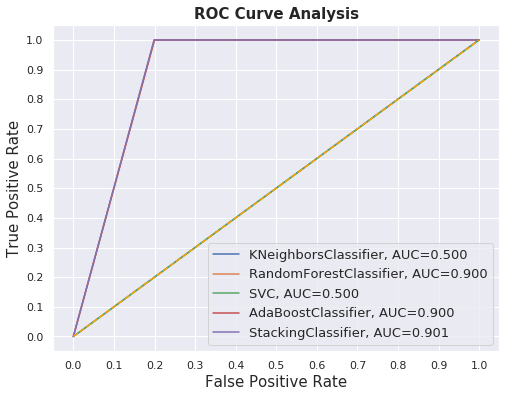

In [21]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

optimal_classifiers = [
    KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"]),
    RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42),
    SVC(kernel="rbf", C=opt_params["svm_c"],gamma=opt_params["svm_gamma"], random_state=42, probability=True),
    AdaBoostClassifier(n_estimators=opt_params["ab_estimators"], random_state=42),
    StackingClassifier(classifiers=classifiers_for_stacking, meta_classifier=lr)
]

for cls in optimal_classifiers:
    model = cls.fit(optimum_x_train_two, y_train_two)
    yproba = model.predict_proba(X_validation)[::,1]
    
    fpr, tpr, _ = roc_curve(y_validation,  yproba)
    auc = roc_auc_score(y_validation, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### 10. Train the method that gives the most accurate predictions so far (i.e. the highest overall accuracy) on the original train set after applying the best feature selection and normalization strategy and compute predictions on the samples of the test set(s) for which the true labels are available. Report the same accuracy measures as in step 5.

In [22]:
clf = KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"]
dump_metrics_without_cv(normalized_x_train, y_train, normalized_x_test, "Stacking Ensemble", clf)

ValueError: Found input variables with inconsistent numbers of samples: [1303, 1629]

### 11. Do literature review and find publications on the same topic. Which methods performed the best? Compare them with the methods you developed in this project. Can you improve your methods using the techniques implemented in the literature? Suggest ideas for improvement.